# Ho-Lee model

Consider the generic HJM Framework where the instantaneous forward rate follows the dynamic:

$$ df(t,T) = \alpha(t, T) dt + \sigma(t, T) dW^{\mathbb{Q}}_t$$

Hull white model:

The model is defined as a particular case of the HJM with $\sigma(t. T) = \sigma$. Thanks to the no-arb condition the short rate can be expressed as:

$$ dr_t = df(t,t) =  (\partial_t f(0,t) + \sigma^2 t) dt + \sigma dW^{\mathbb{Q}}_t$$

and The price of a zero coupon bond is given as:

$$ B(t, T) = \mathbb{E}^{\mathbb{Q}}\left(e^{-\int_t^T r_s} ds | \mathcal{F}_t\right) $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from research.config import plots

plots.init(width=10)

%matplotlib inline


In [2]:
from scipy.optimize import minimize

In [3]:
from research.config import plots
from research.fixedincome.curves.parametrization import Svensson
from research.utils import normalize

We start by loading the the instantaneous forward rate downloaded from the ECB website that can be found in:
[ECB Europa website](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html)

In [4]:
yc = pd.read_csv('ecb_yc.csv', header=0)

We plot the term structure

The parameters corresponding to this curve can also be retrieved from the website and are:

In [5]:
# Source ECB data
beta_0 = 1.229592
beta_1 = 0.680969
beta_2 = 2.763221
beta_3 = 3.221784
tau_1 = 13.010220
tau_2 = 0.463933

In [6]:
svensson_curve = Svensson(beta_0, beta_1, beta_2, beta_3, tau_1, tau_2)

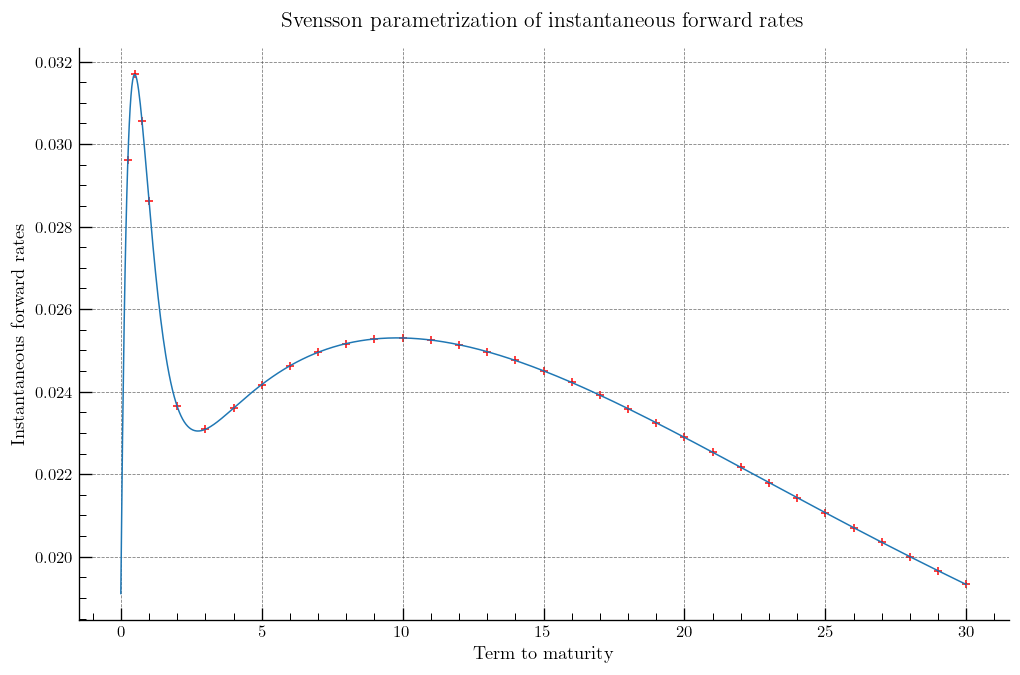

In [7]:
yc.plot.scatter(x='T', y='IFR', marker='+', color='red');
svensson_curve.plot_forward()

We can also calibrate the parameters ourselves. Let's consider a mean-square error minimization

In [8]:
def calibration(func, yc, params):

    def objective(params):
        return np.power(yc.IFR*100 - func(*params, theta=yc['T'])*100, 2).sum()
    
    options = {'ftol':1e-6, 'maxiter':5000}
    res = minimize(objective, params, method='L-BFGS-B', options=options)
    return res.x, objective(res.x)

In [9]:
def ifr(*params, theta=None):
    return Svensson(*params).instantaneous_forward_curve(theta)

In [10]:
optimal_params = None
tmp = np.inf

for i in range(100):
    print(f'\rCalibrating: iter = {i}', end='')
    np.random.seed()
    params = 3 * np.random.rand(6)
    params, value = calibration(ifr, yc, params)
    if value < tmp:
        tmp = value
        optimal_params = params
    if value < 1e-8:
        print(f'\nOptimal parameters found after {i} iterations')
        print(optimal_params)
        break

Calibrating: iter = 14

/home/abenmoussa/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/abenmoussa/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Calibrating: iter = 99

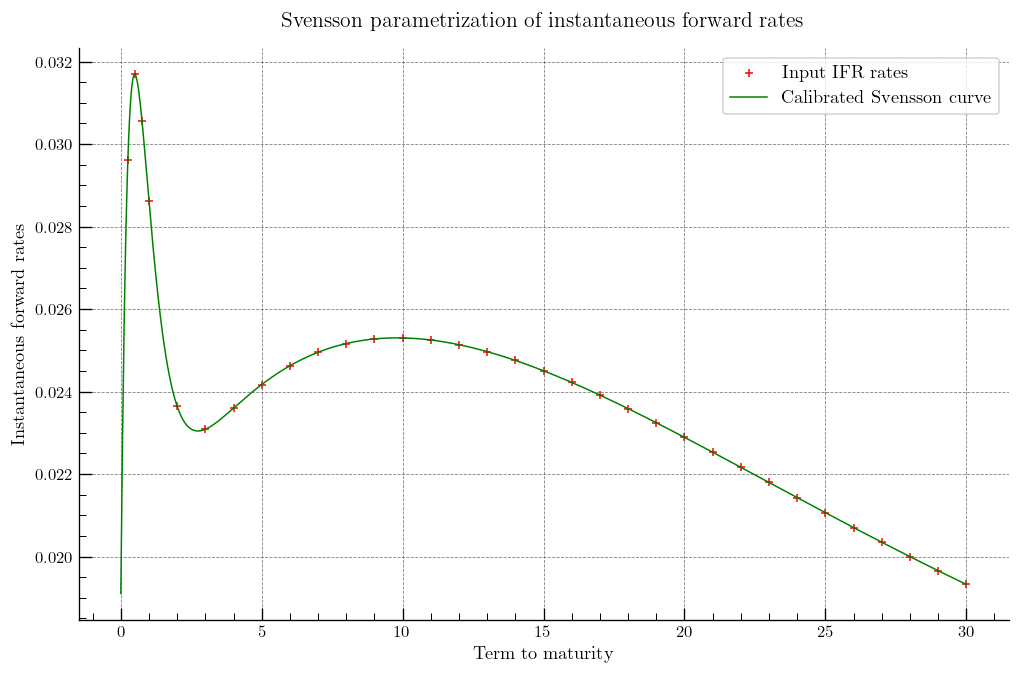

In [11]:
yc.plot.scatter(x='T', y='IFR', marker='+', color='red', label='Input IFR rates');
Svensson(*optimal_params).plot_forward(color='green', label='Calibrated Svensson curve')
plt.legend();

To compute the bond prices using the Ho-Lee model we will approximate the integral using a left point method. One can use any integral approximation scheme: Trapezoidal, Simpson, Gauss quadratures.

In [12]:
def zc_from_ho_lee(T, sigma, nb_steps=365, nb_paths=100_000):
    
    h = T / nb_steps
    r = np.zeros((nb_steps+1, nb_paths)) 
    r[0, :] = svensson_curve.instantaneous_forward_curve(0)

    for s in range(1, nb_steps+1):
        t = s * h
        df = svensson_curve.ifr_derivative(t)
        Z = np.random.normal(0, 1, nb_paths)
        r[s,:] =  r[s-1,:] + (df + sigma**2 * t) * h + sigma * np.sqrt(h) * Z    
    r[1:, :] = r[:-1, :] * h
    r[0, :] = 0
    r = np.exp(-r.cumsum(axis=0)).mean(axis=1)
    return r

In [13]:
T = 30
sigma = .02
nb_steps = 10_000
nb_paths = 40_000

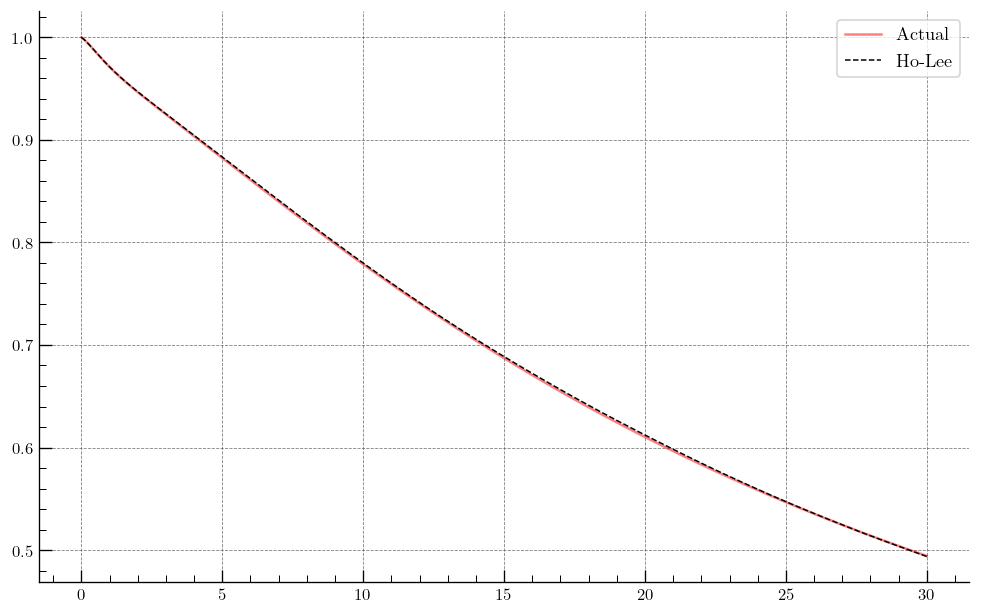

In [14]:
zchl = zc_from_ho_lee(T, sigma, nb_steps=nb_steps, nb_paths=nb_paths)
t = np.linspace(0, T, nb_steps+1)

zccy = svensson_curve.discount_curve(t)
plt.plot(t, zccy, label='Actual', lw=1.5, color='red', alpha=.5)
plt.plot(t, zchl, label='Ho-Lee', color='black', ls='--')
plt.legend()